# Paper Reading: XLNet: Generalized Autoregressive Pretraining for Language Understanding

## Application:
Text Ranking, Natrual Language Inference, Sentiment Analysis, Question Answering

## Comparison between BERT and XLNet:

### Pros/Cons of BERTs
- Pros:
   - Bidirectional context modeling
   - Autoencoding remove noise(AE)
- Cons:
   - rely on input-corrupted mask, neglect dependency between masked positions
   - Suffers from `pretrain-finetune discrepancy`,owning to downstream tasks do not include [MASK] symbols
### Learn BERT's Lessons: What about XLNet?
1. Learning bidirectional context by maximizing expected likelihood over all permutations of factorization order
2. Autoregression
3. Learning from SOTA `Transformer-XL` and reparameterize,improving tasks involving a longer text sequence.


## Two Pretraining Objectives

### Autoregressive Language Model (AR LM)
- Use context word to predict next following word, from left to right, or from right to left.
- Given a word sequence `x=(x1,x2,...,xT)`, factorizing the likelihood into a forward product `p(x)=∏p(x_t|x_<t)` for *t⊂(1,T)*, and a backward product `p(x)=∏p(x_t|x_>t)` for *t⊂(T,1)* to estimate the probability distribution of text corpus.
- Evaluation:
   - Only can use upward text information or downward text information, cannot use both upward and downward info at the same time.
      - While, ELMO joint two-ways together simply. It is not effective
   - Perform well in generative tasks. Text generation (text summarization,text interpretation) in reality start from left to right, matching the attributes of AR LM.
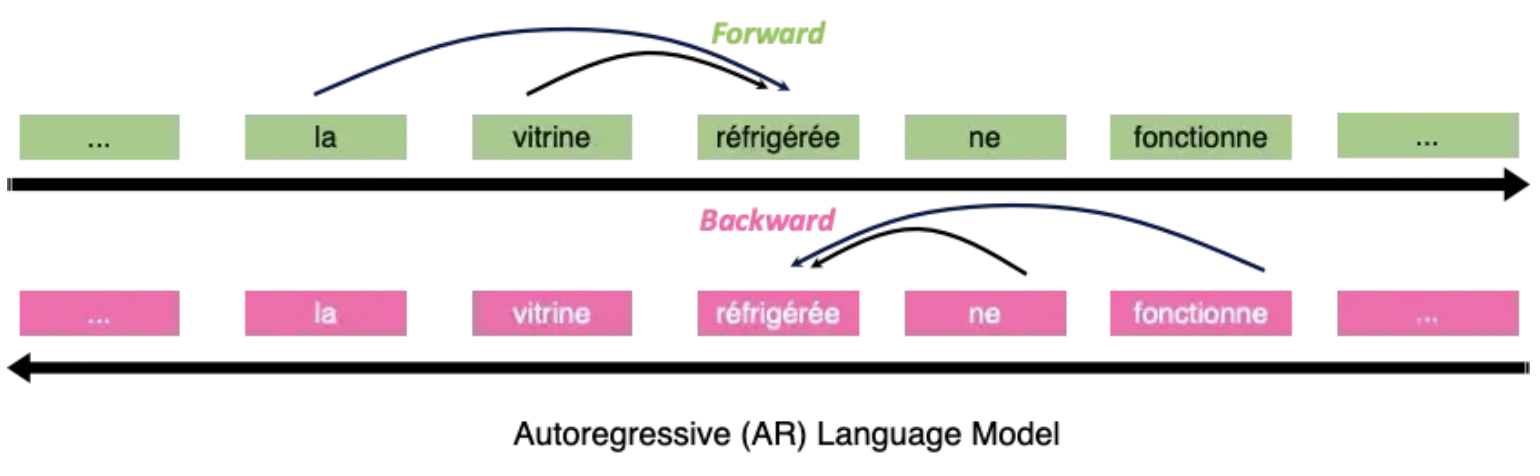
- Log likelihood object function:
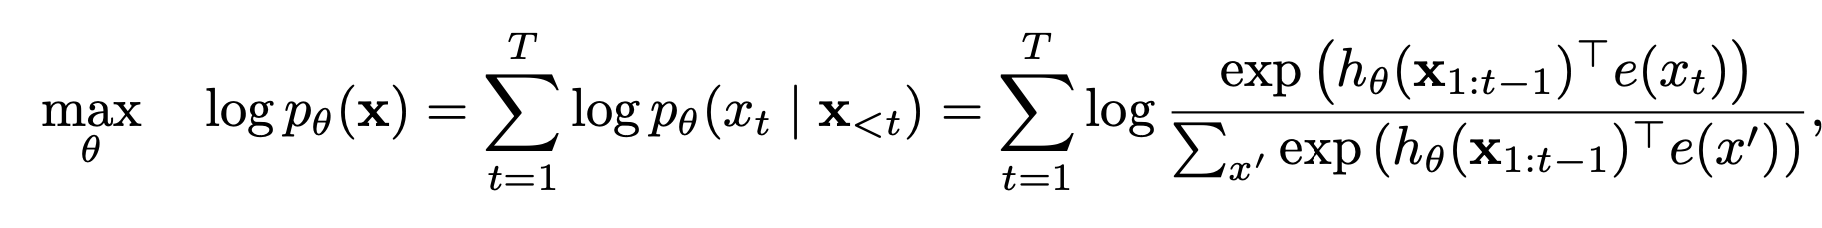
- Notation:
   - `h𝛉(x_1:t-1)`:context representation produced by neutral model
   - `e(x)`:embedding of x



### Autoencoder Language Model (AE LM)
- Reconstruct the original data from the input corrupted by label [MASK]. It utilizes the bidirectional context for recovery with looking for upward and downward context simultaneously.
- There exists gaps between fine-tune and pre-train because of noise [MASK], called **pretrain-finetune discrepancy**.
截屏2022-12-01 18.28.12.png


## XLNet Model Architecture 

### Permutation Language Modeling
- Expression:
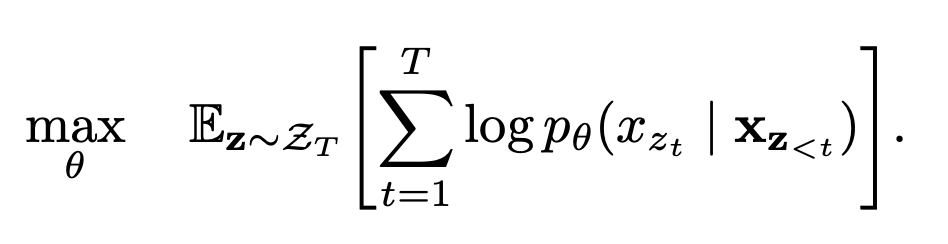

- a sequence `x` with length `T`, position regard as `t`, there are ***T!*** different orders to perform valid autoregression factorization.
- If parameters are shared across all factorization orders, to gather information from all position on both sides.
- Notation:
    - `Z_T`: set of all possible permutations 
    - `z~Z_T`:factorization orders
    - `z_t`:t-th element
    - `z_<t`:first t-1 element
    - 𝛉 in log likelihood is shared across all factorization orders during training. x_t can see all the tokens, getting biredirection information.
- This function is only about factorization orders,not sequence order. Use the `positional encoding` corresponding to original sequence, rely on `attention mask` in Transformers is necessary.
   - The standard LM parmeterization fails because the ground-truth distribution of two positions should be different.

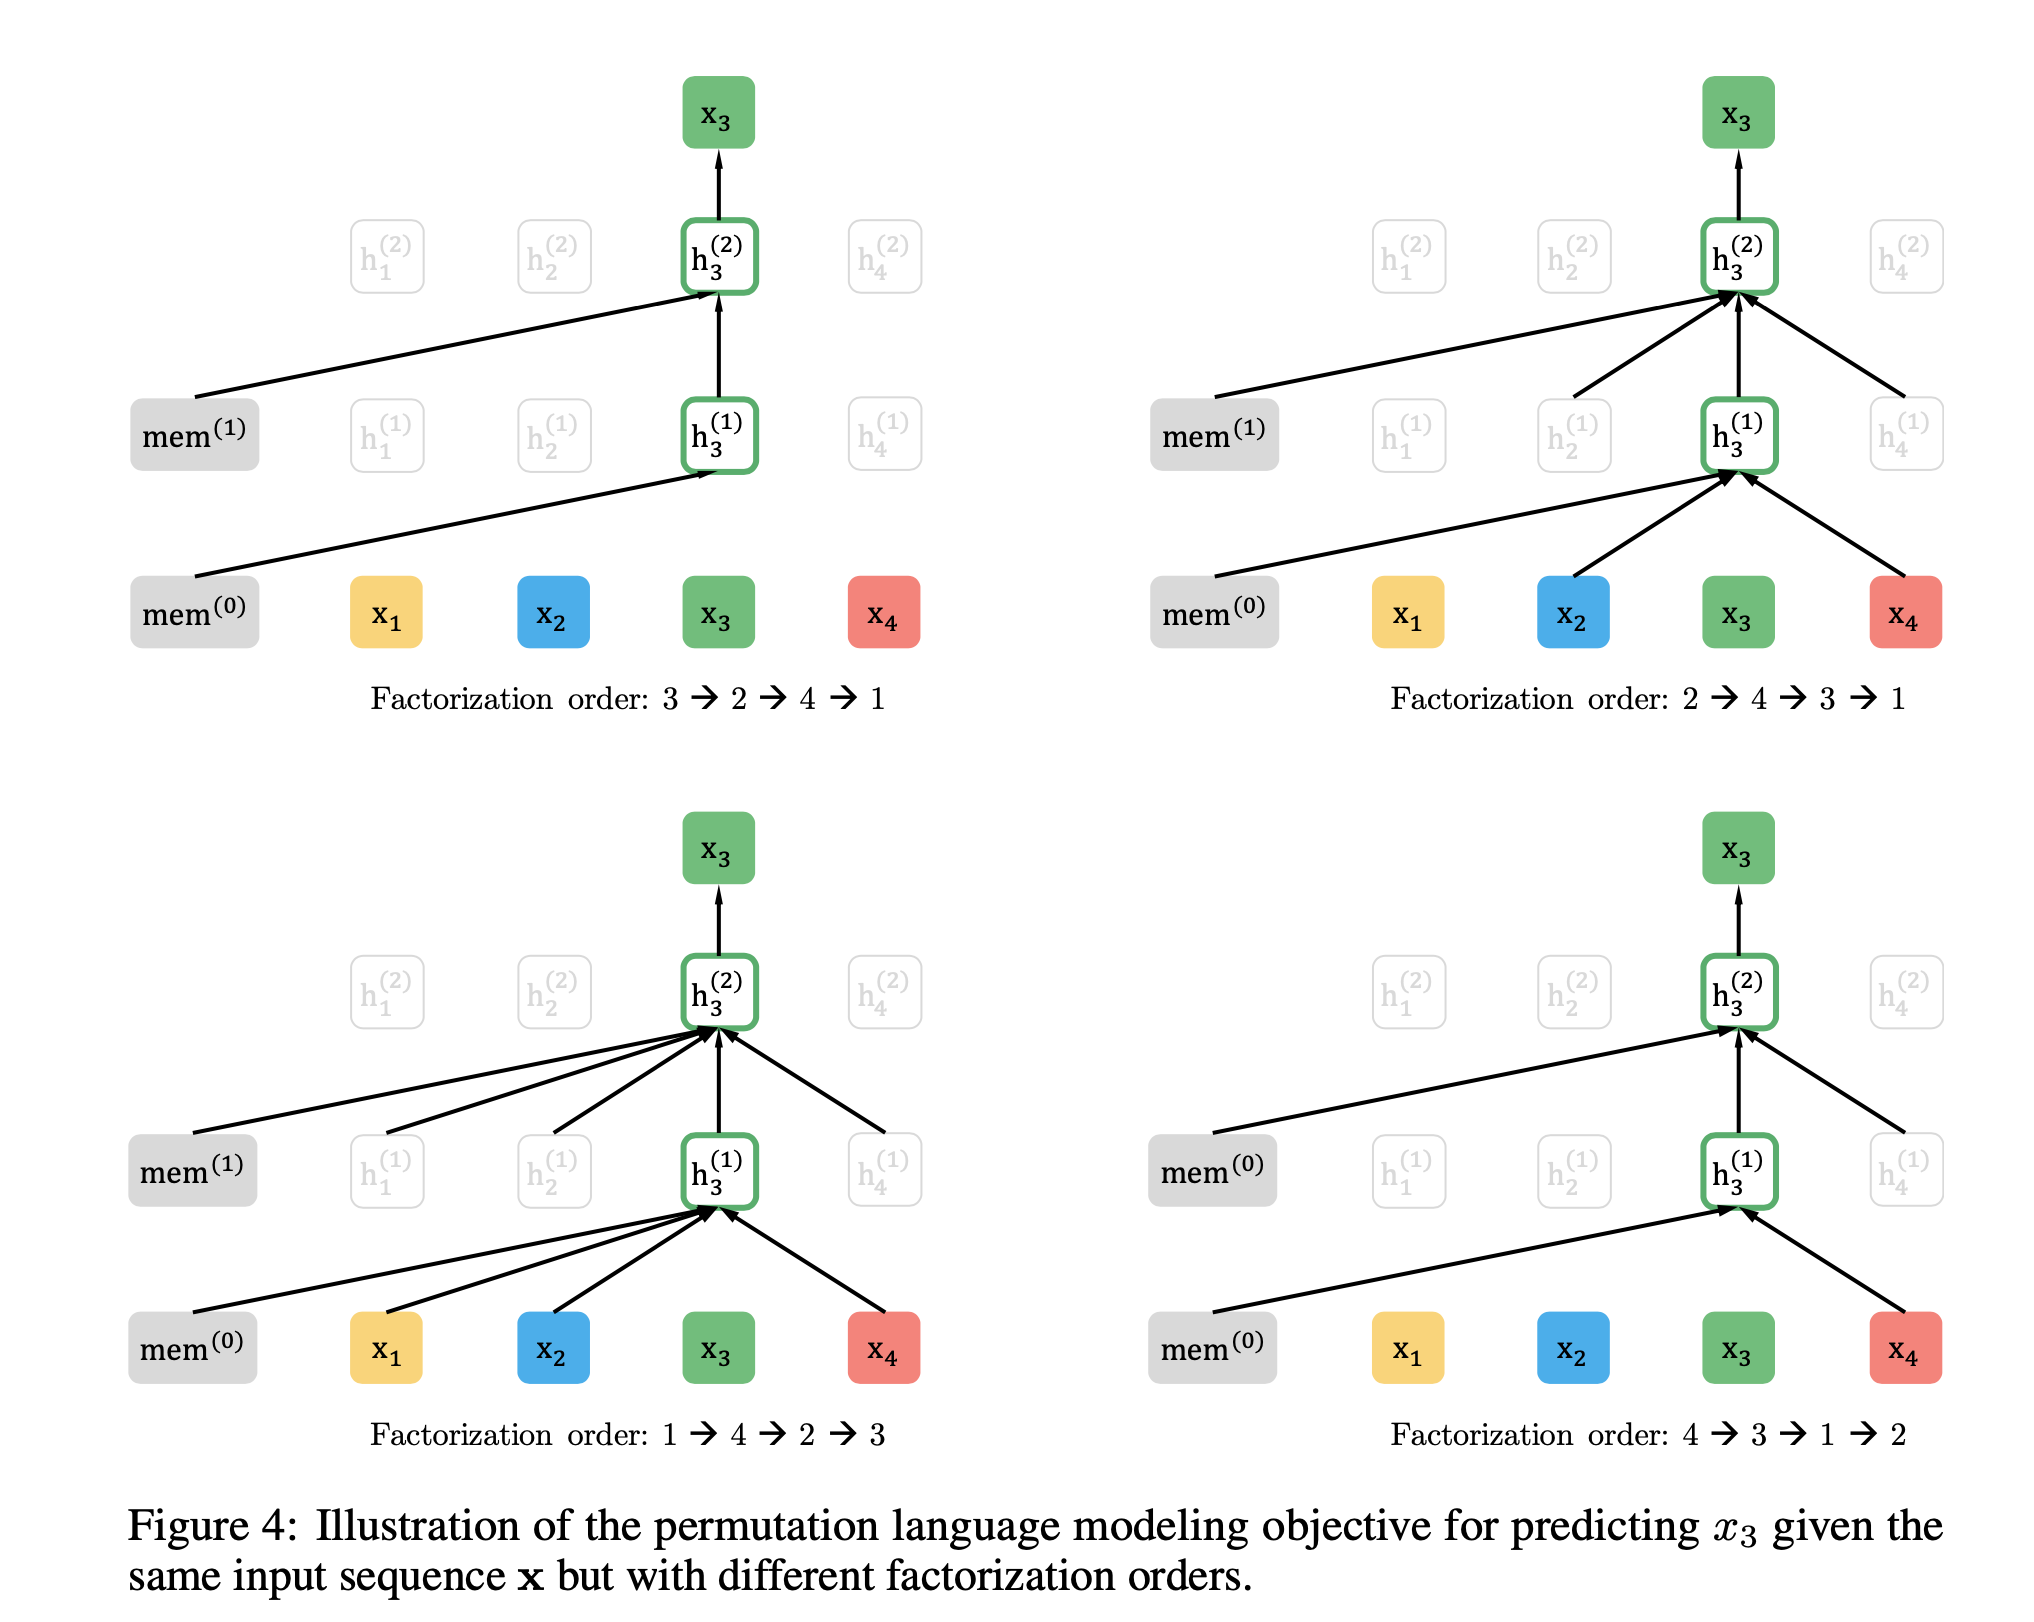

Give the order randomly for **factorization**.However, the sequence's order remain the same using positional encoding.

- We need to predict token X_zt at z_t position only based on position z_t
- Predict token x_zt with all the contents of the tokens before x_zt encoded.

- re-parameterize the next-token distribution as target position
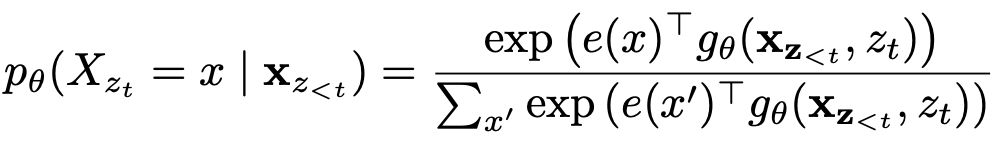
- take target position `z_t` as input

### Architecture: Two-Stream Self-Attention for Target-Aware Representation
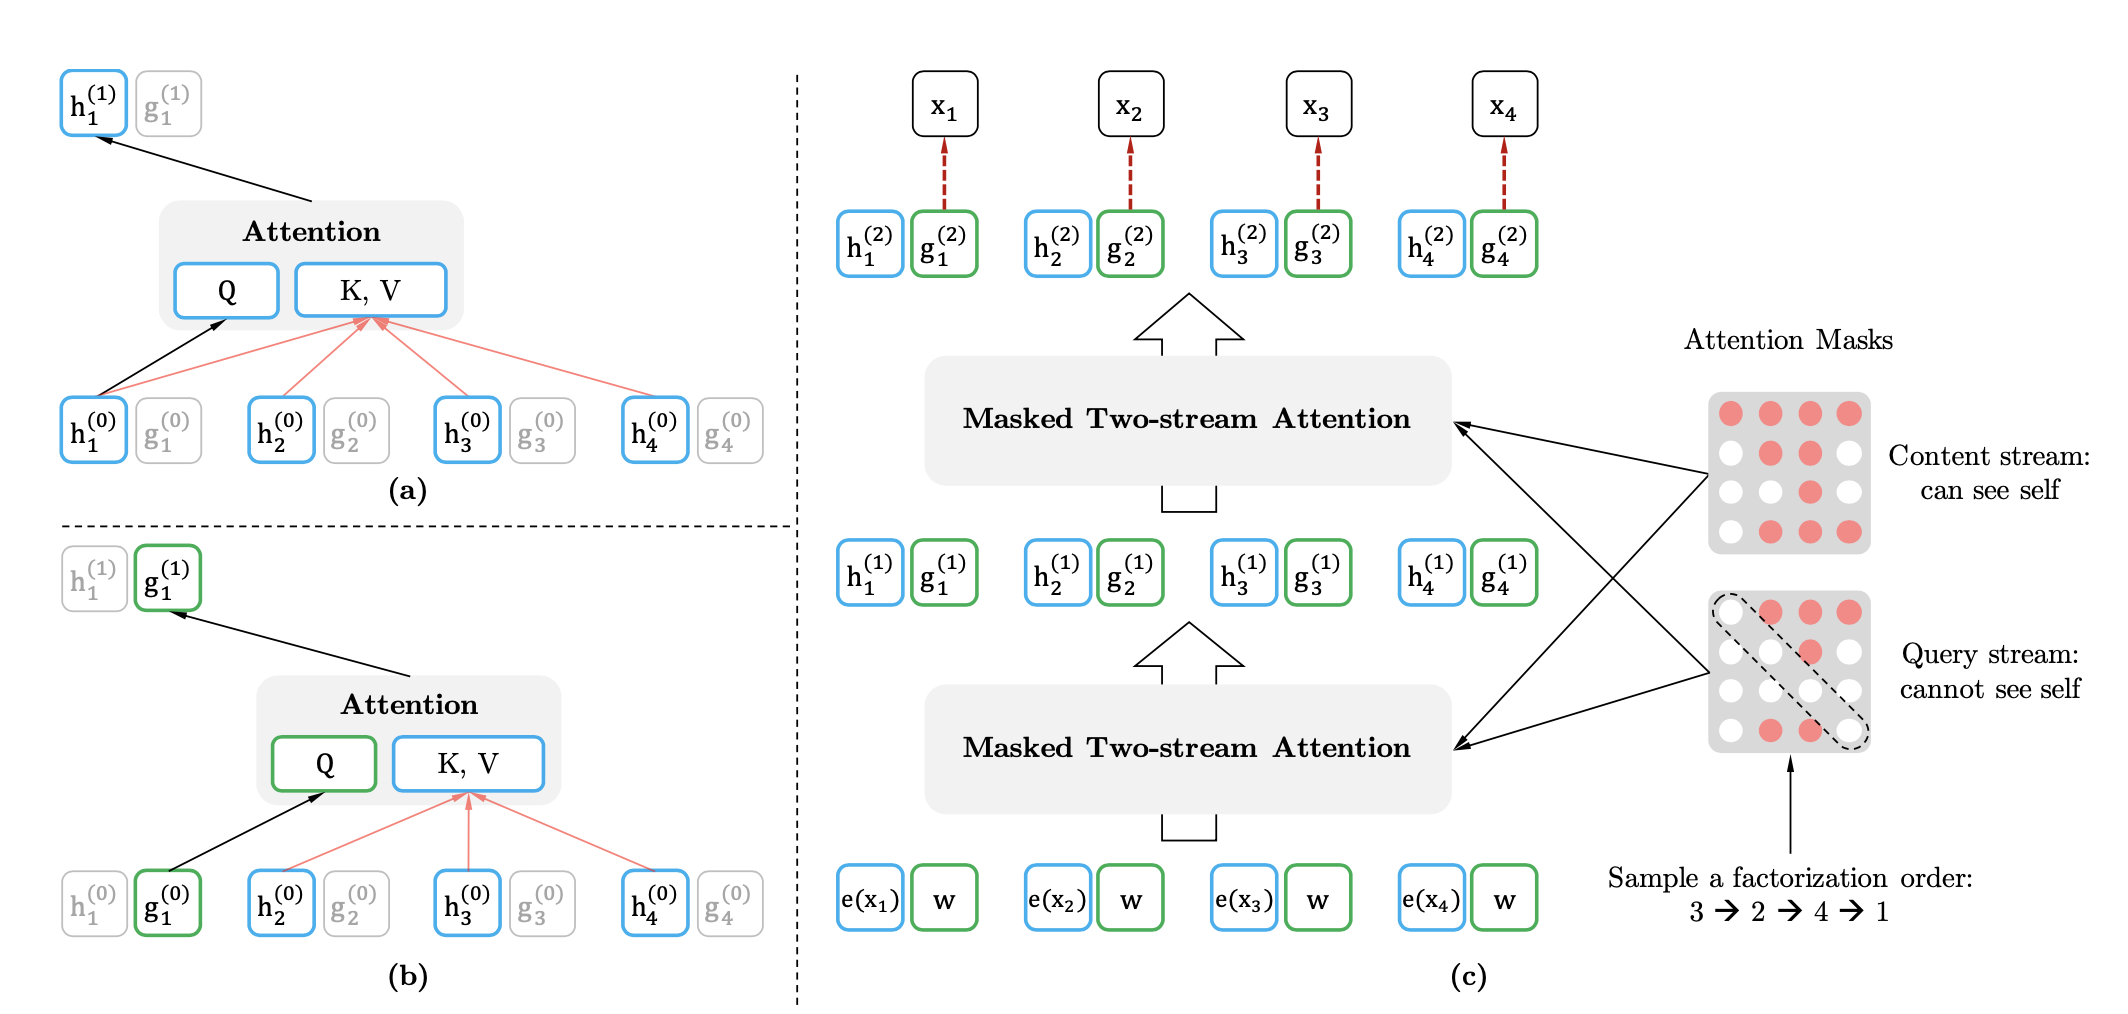

(a) content stream:contains both positon and content information, same with self-attention
(b) query stream: has no access information about content x_t,only contains **position information**
(c) two-stream attention
- In the sample graph above, attention masks in diagonal. In first row, the first point can see point in position 2,3,4. In the second row, the second point can see the third point.
- In this sample factorization order, 2 can see context above 3, 4 can see 3 and 2
   - Intuition: stand at target position `z_t` to gather information from the context `Xz<t`
- content representations:
    - `h_zt=h𝛉(Xz≤t)`
    - encode both context and x_zt
    - Similar to the K,V in self-attention 
- query representations:
    - `g_zt=g𝛉(Xz<t,z_t)` 
    - has access to contextual information `Xz<t` and position `z_t`
    - Similar to the Q in self-attention 
- In the graph above,the blue label contains input e(x) word embedding, while the green label contains relative positional encoding.

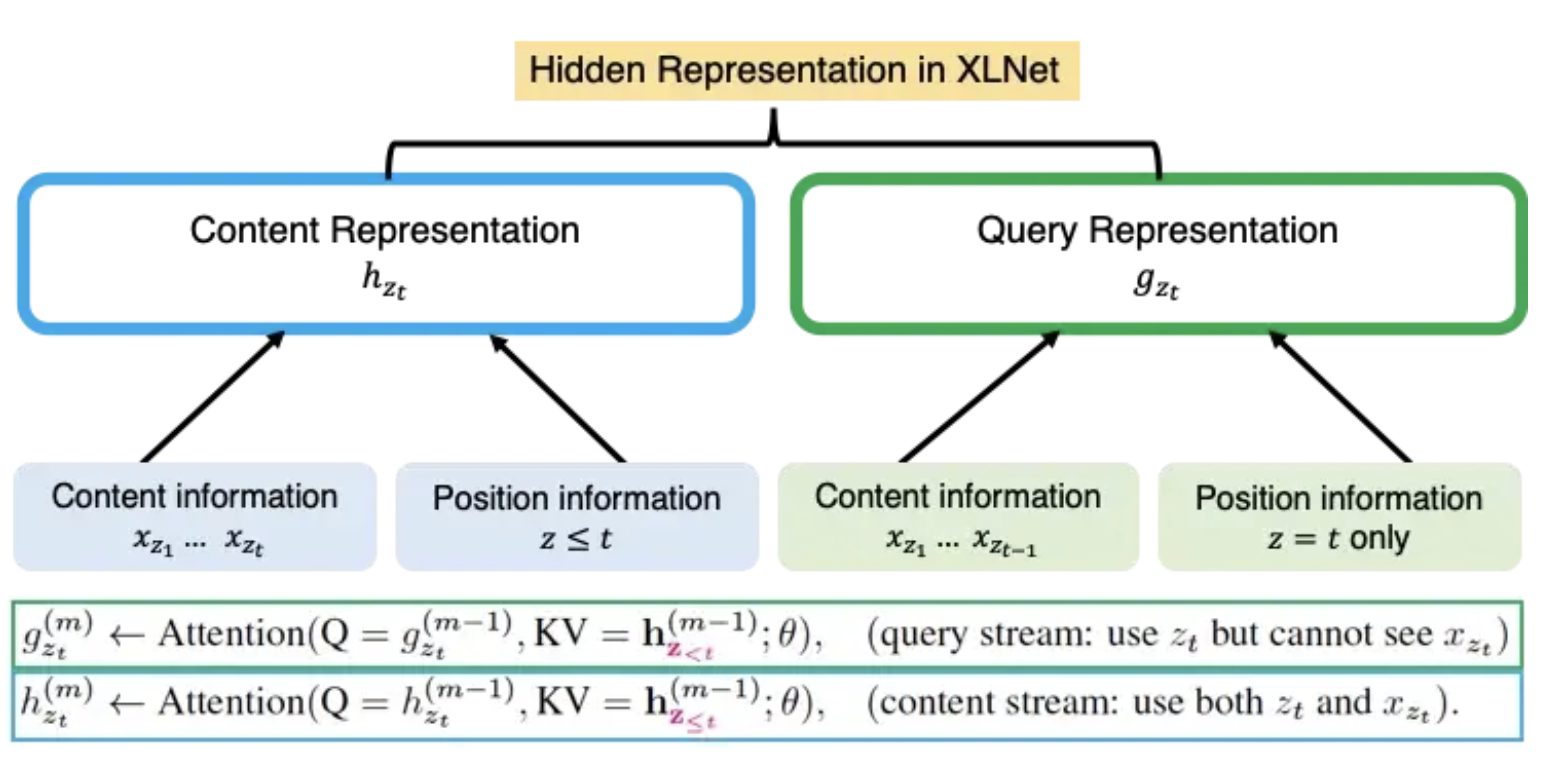

### Partial Prediction
- if we predict with every single position,causing slow convergences. To optimize it, we only predict the last tokens in a factorization order.
  - the aim for selecting only last positions: get more information to use in prediction as much as possible
  - `K`:1/K tokens are selected for predictions. The optimize selection is K=6 or K=7(1/K:14.3%~16.7%)
- Split z into non-target subsequence `z_≤c` and target subsequence `z_>c`, where `c` is cutting point.
- We get new objective function for given non-target subsequence, maximizing the log likelihood function of target part
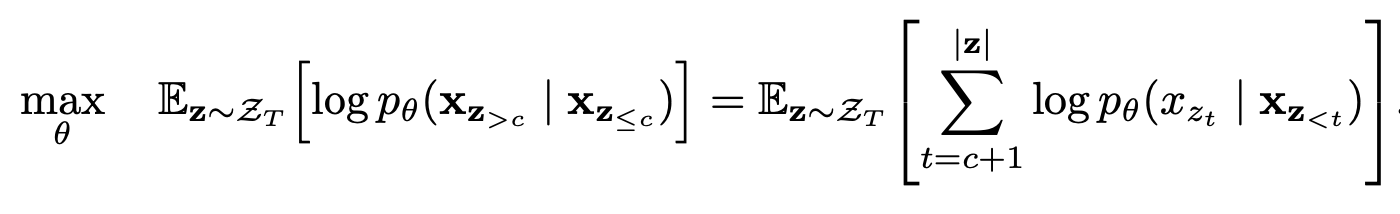

### Transformer XL
#### Segment Recurrence Mechanism
- Avoid the context fragmentations embodied by fixed-length segment processing.
- Divid long text into several segments whose length=512. 
- After learning one part, keep and save calculated hidden states into a memory.
- when calculating this part, combine former hidden states saved in memory with this part hidden states together, regarding as K and V of attention mechanism. As a result, we get a longer context information.
   - Catching and reusing the memory without knowing the factorization order of previous fragment.


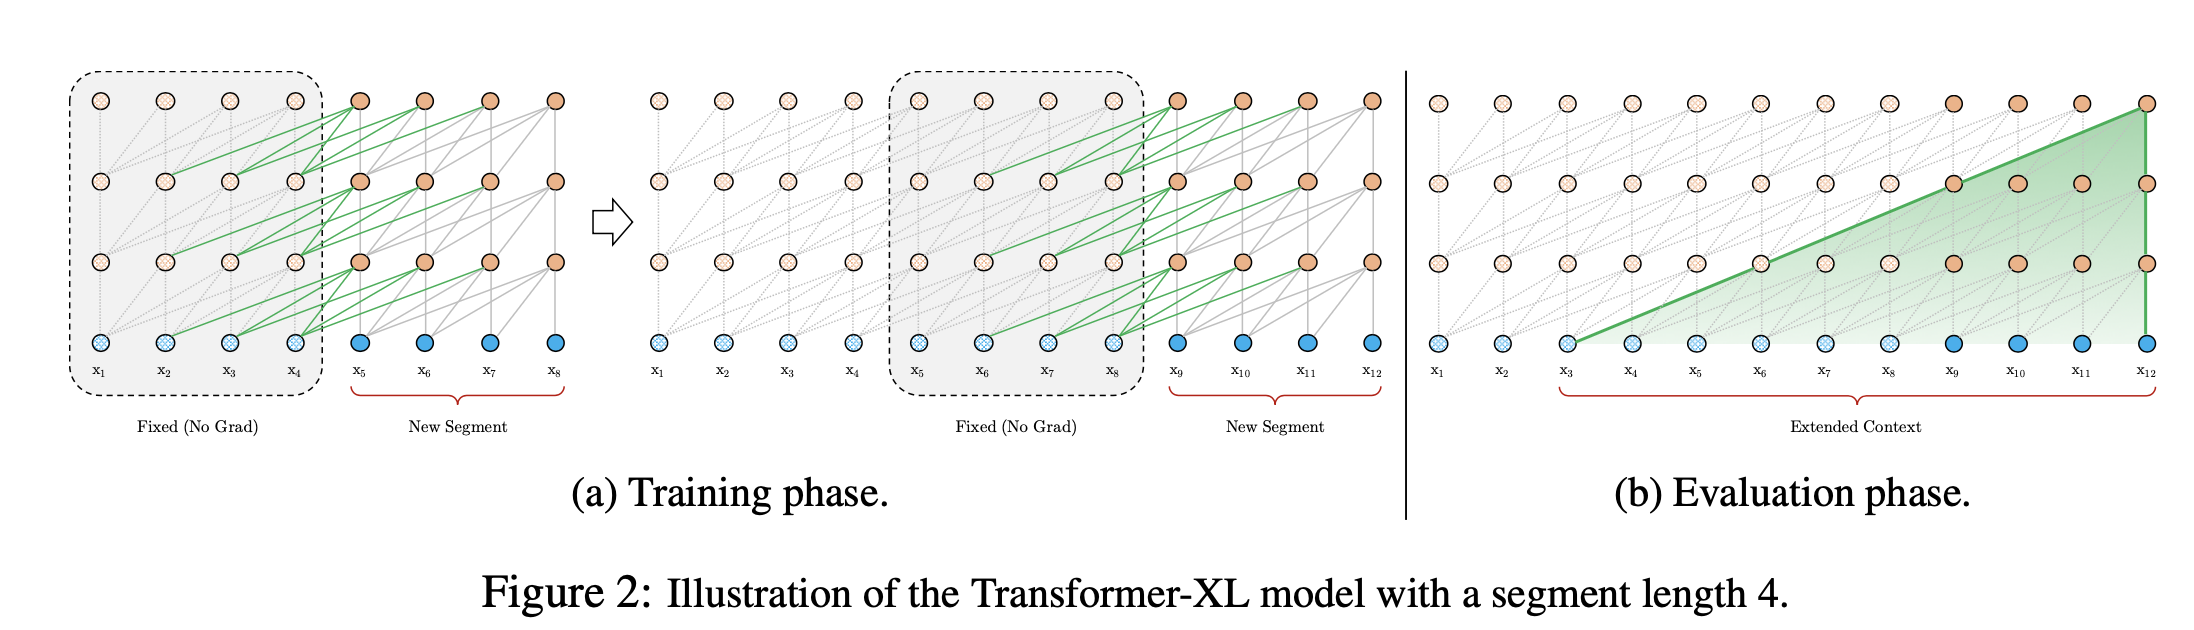

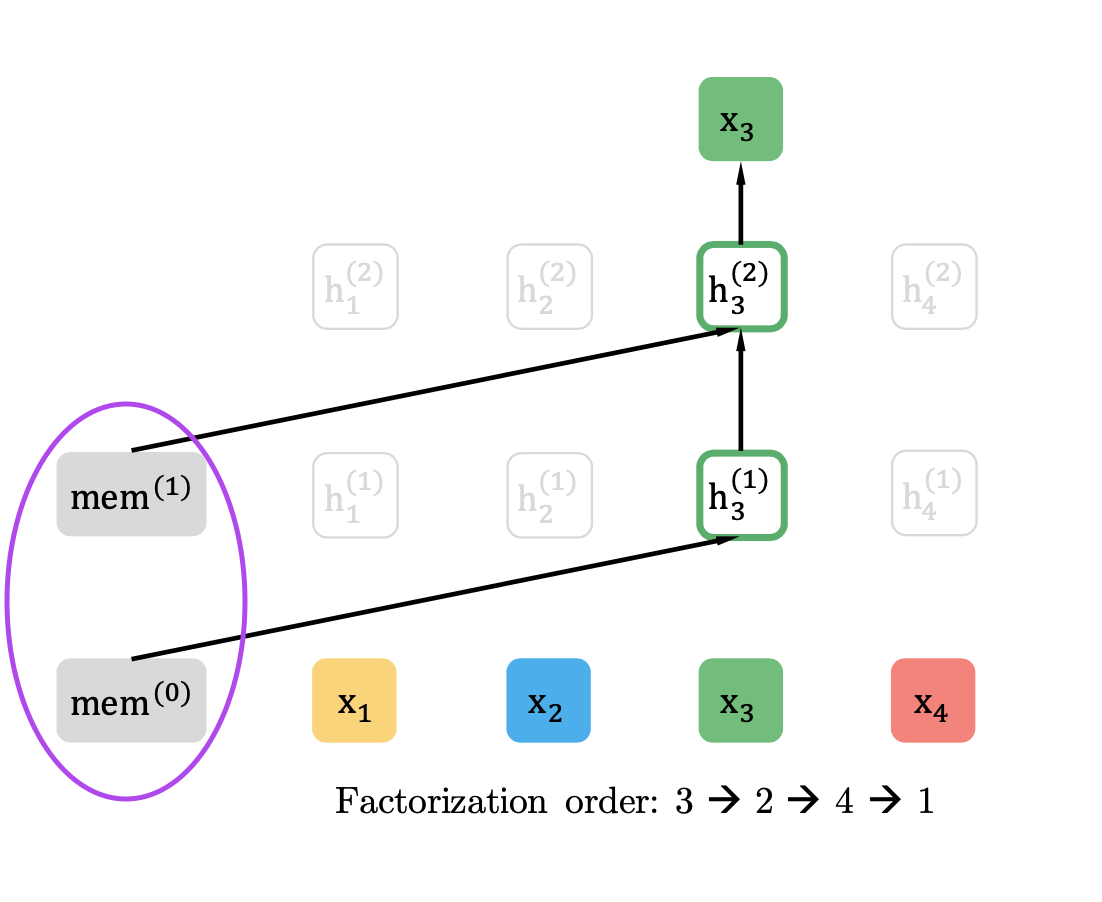

#### Relative Positional Encoding
- Only model the relationship between positions, whether two position `i` and `j`
    - from the same segment (`S_ij=s+`), OR
    - which specific segment they are from (`S_i,j=s-`)
- Compute an attention weight:`aij=(qi+b)^T *s_ij` and added to the normal attention weight
   - `qi`: query vector
   - `b`: learnable head-specific bias vector
   - `s_ij`: segment encoding
- Evaluation:
   - inductive bias to improve generation
   - fine-tuning part can have more than two input segments, which is impossible for absolute position encoding in BERT.

##### Absolute Segment Encoding
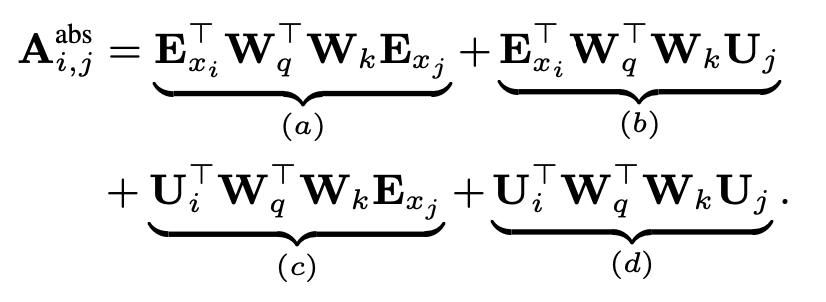

- `E`: word embedding, contains context information
- `U`: absolute position encoding
- `W`: QK conversion mechanism in attention

##### Relative Segment Encoding
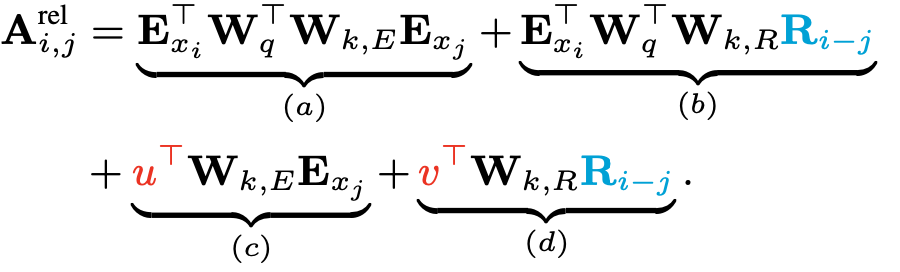

- can be applied in music generation and machine translation
- Replace `Ui` and `Uj` into `Ri-j`. 
   - `R`: **sinusoid encoding matrix** without learnable parameters
   - `Ri-j`: relative counterpart, only relative distance matters.
- Introduce trainable parameter `u` to replace U*W. The attentive bias towards different words should be the same regardless of the query position.
- trainable parameter `v` has the same reason.
- separate 2 weight metrics `W_k,E` and `W_k,R`to produce **content-based** key vector and **location_based** key vector correspondingly.
- `(a)`: content-based addressing
- `(b)`:content-dependent position bias
- `(c)`: global content bias
- `(d)`: global positon bias


## References
- 深度学习论文笔记XLNet:Generalized Autoregressive Pretraining for Language Understanding.https://zhuanlan.zhihu.com/p/403559991
- What is XLNet and why it outperforms BERT? https://medium.com/towards-data-science/what-is-xlnet-and-why-it-outperforms-bert-8d8fce710335
- Understanding Language using XLNet with autoregressive pre-training.https://medium.com/@zxiao2015/understanding-language-using-xlnet-with-autoregressive-pre-training-9c86e5bea443
- 飞跃芝麻街：XLNet 详解.https://zhuanlan.zhihu.com/p/71916499
- Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context https://arxiv.org/pdf/1901.02860.pdf
- Transformer-XL Explained: Combining Transformers and RNNs into a State-of-the-art Language Model.https://medium.com/towards-data-science/transformer-xl-explained-combining-transformers-and-rnns-into-a-state-of-the-art-language-model-c0cfe9e5a924
- XLNet HuggingFace Docs.https://huggingface.co/docs/transformers/main/en/model_doc/xlnet#transformers.XLNetLMHeadModel



# Demo:  Multiple Choice， Question Answering, Text Summarization with XLNet

In [1]:
!pip install transformers 
!pip install sentencepiece
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 28.0 MB/s 
     |████████████████████████████████| 182 kB 53.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import XLNetTokenizer,XLNetForMultipleChoice
from torch.nn import functional as F
import torch

### Multiple Choice Q&A

In [8]:
#check out pretrain method to load weight and select model with appropriate size
tokenizer=XLNetTokenizer.from_pretrained('xlnet-base-cased')
MCModel=XLNetForMultipleChoice.from_pretrained('xlnet-base-cased',
                                               return_dict=True) # Whether or not to return a ModelOutput instead of a plain tuple.
prompt='Who found Law of Universal Gravitation?'
answers = [ "Newton", "Galileo","James Watt", "Nikola Tesla"]
encoding = tokenizer([prompt, prompt, prompt, prompt], answers, return_tensors="pt", padding = True)
outputs = MCModel(**{k: v.unsqueeze(0) for k, v in encoding.items()})
logits = outputs.logits
softmax = F.softmax(logits, dim = -1) #https://pytorch.org/docs/master/special.html#torch.special.softmax
index = torch.argmax(softmax, dim = -1)
print("The correct answer is", answers[index])

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultipleChoice: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultipleChoice were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The correct answer is James Watt


### Extractive Q&A

In [21]:
from transformers import XLNetForQuestionAnsweringSimple
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
ExtractiveModel = XLNetForQuestionAnsweringSimple.from_pretrained("xlnet-base-cased",return_dict = True)
question='Who is the founder of Microsoft?'
text='Microsoft was founded by Bill Gates and Paul Allen on April 4, 1975.'
inputs = tokenizer.encode_plus(question, text, return_tensors='pt')
output = ExtractiveModel(**inputs)
start_max = torch.argmax(F.softmax(output.start_logits, dim = -1))
end_max = torch.argmax(F.softmax(output.end_logits, dim=-1)) + 1 
answer = tokenizer.decode(inputs["input_ids"][0][start_max : end_max])
print(answer)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForQuestionAnsweringSimple: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForQuestionAnsweringSimple from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnsweringSimple from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnsweringSimple were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


and Paul Allen on April 4,


### Text Summarization

In [3]:
text='''
Four sets of major social policy reforms took place during the Hu–Wen era: the establishment of a social insurance system, the building of a social assistance sys- tem, the campaign of “Building a new socialist countryside,” and the efforts to improve the labour conditions and social protection for migrants. A common theme for all these reforms was a push for the unification of the unequal and frag- mented urban–rural–migrant systems. While these reforms have helped narrow some of the urban–rural–migrant gaps, the imbalance across these divisions still persists and may take a much longer time to eliminate.
First, the most important social policy reform during the Hu–Wen era was the establishment of a comprehensive social insurance system. The two pillars of modern social insurance systems, pensions and health insurance, were both expanded to provide coverage to urban non-employees, rural residents and migrants. The urban–rural gaps in benefit levels persisted, but began to narrow. The issuance of the 2010 Social Insurance Law was a milestone in social policy development and a major achievement of the Hu–Wen administration in building a harmonious society. This system provided a floor of social protection for the Chinese population regardless of employment status and across the urban–rural division.14
Specifically, the former urban pension system covered only civil servants and employees of public institutions and state-owned enterprises (SOEs) and was paid for by central revenue and contributions made by SOEs. Since 1991, follow- ing a series of local pilot projects, the State Council worked to transform the pre- vious pay-as-you-go pension system for urban employees into a dual system of social pooling and individual accounts. The social pooling system was earnings-based,pay-as-you-go, with defined benefits, while the individual accounts system relied on mandatory individual contributions. In 2005, the State Council issued a new decision that required that basic pensions take into account both average and individual wages before retirement and the number of years of individual contributions.
Urban non-employees and rural residents, however, were mostly left out of the pension system. The Hu–Wen administration worked to address this gap during its second term. Based on several pilot projects in different cities that began in 2009, the urban resident pension system was established nationwide in 2012 for urban non-employees, with funding from both government subsidies and individual contributions. Based on pilot projects during the early 2000s, the government launched the New Rural Social Pension System in 2009 to provide pension coverage for rural residents. It also provided a national framework to allow migrant workers to participate in the basic pension system. This system included a non- contributory basic pension fully (in the central and western regions) or half (in the eastern region) funded by the central government and a highly subsidized personal savings account. In 2014, the rural pension system was unified with the urban resident pension system to allow equal access and quality of pension systems for urban and rural residents and facilitate rural–urban mobility.15
The downside of these expansions was that the benefit levels for the systems for urban non-employees and rural residents remained very low on average and var- ied substantially across localities.16 In many localities, the average pension ben- efits were much lower than the dibao assistance standards, which were meant to reflect the local minimum level of livelihood. The participation rate was espe- cially low among poor residents due to the lack of resources and motivation for making monthly contributions. Migrant workers, who were allowed to partici- pate in the rural pension system, were often reluctant to do so due to uncertainty about the ability to carry over the benefits across localities. Urban employees, meanwhile, received pension benefits in accordance with their job positions and ranks.
The transformation of China’s health insurance system during this period par- alleled that of the pension system. The expansions in the health insurance system was signified by the 2009 State Council issuance of the Implementation Plan for the Priorities of the Health Care Reform, which aimed to expand basic medical insurance coverage and government subsidies at various levels and to provide a full array of basic public health services
'''

In [4]:
!pip install bert-extractive-summarizer
from summarizer import Summarizer,TransformerSummarizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
summaryModel = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")
full = ''.join(summaryModel(text, min_length=60))
print(full)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Four sets of major social policy reforms took place during the Hu–Wen era: the establishment of a social insurance system, the building of a social assistance sys- tem, the campaign of “Building a new socialist countryside,” and the efforts to improve the labour conditions and social protection for migrants. First, the most important social policy reform during the Hu–Wen era was the establishment of a comprehensive social insurance system. The two pillars of modern social insurance systems, pensions and health insurance, were both expanded to provide coverage to urban non-employees, rural residents and migrants. In 2014, the rural pension system was unified with the urban resident pension system to allow equal access and quality of pension systems for urban and rural residents and facilitate rural–urban mobility.15
The downside of these expansions was that the benefit levels for the systems for urban non-employees and rural residents remained very low on average and var- ied substanti